In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_data = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_data = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

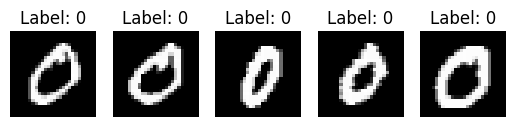

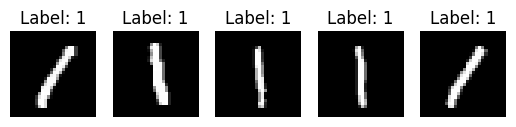

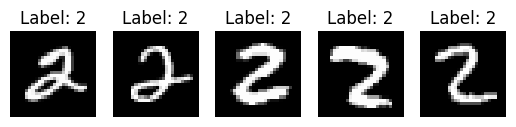

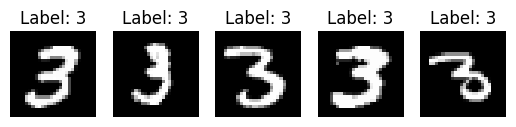

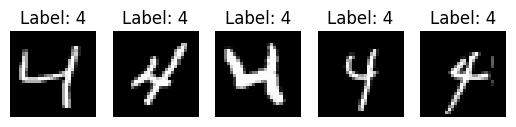

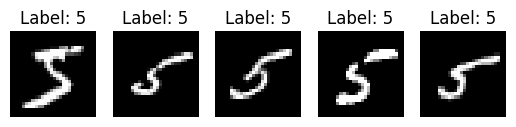

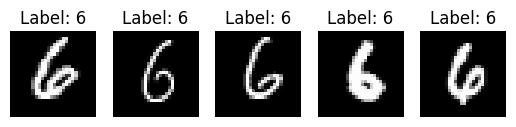

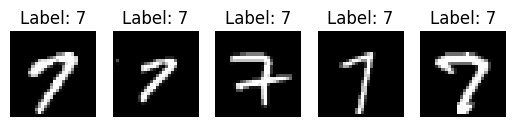

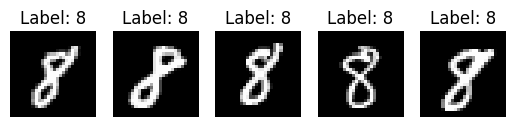

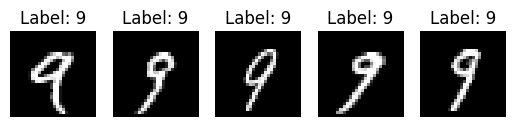

In [3]:
for i in range(10):
    count = 0
    for j in range(len(train_data)):
        if train_labels[j] == i:
            plt.subplot(1, 5, count + 1)
            plt.imshow(train_data[j], cmap='gray')
            plt.title('Label: ' + str(train_dataset[j][1]))
            plt.axis('off')
            count += 1
        if count == 5:
            break
    plt.show()

In [4]:
train_data, val_data = np.split(train_data, [50000])

In [5]:
std = 97
noise_train = np.random.normal(0, std, train_data.shape)
noise_val = np.random.normal(0, std, val_data.shape)
noise_test = np.random.normal(0, std, test_data.shape)

noisy_train_data = train_data + noise_train
noisy_val_data = val_data + noise_val
noisy_test_data = test_data + noise_test

noisy_train_data = np.clip(noisy_train_data, 0, 255)
noisy_val_data = np.clip(noisy_val_data, 0, 255)
noisy_test_data = np.clip(noisy_test_data, 0, 255)
    

In [6]:
train_data = torch.from_numpy(train_data).float()
val_data = torch.from_numpy(val_data).float()
test_data = torch.from_numpy(test_data).float()
noisy_train_data = torch.from_numpy(noisy_train_data).float()
noisy_val_data = torch.from_numpy(noisy_val_data).float()
noisy_test_data = torch.from_numpy(noisy_test_data).float()

In [7]:
noisy_train_data = noisy_train_data/255
noisy_val_data = noisy_val_data/255
noisy_test_data = noisy_test_data/255

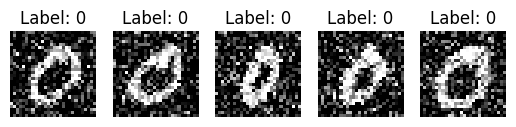

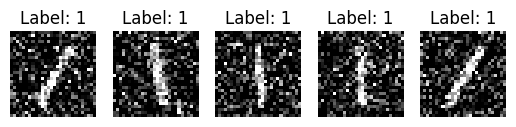

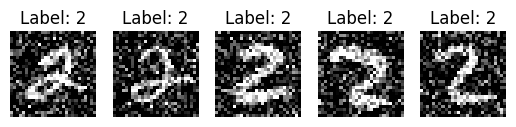

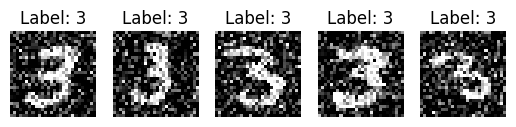

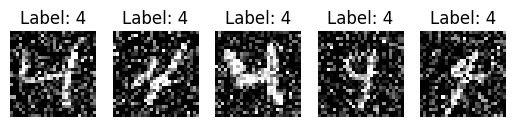

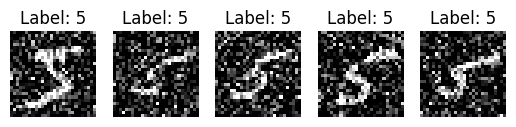

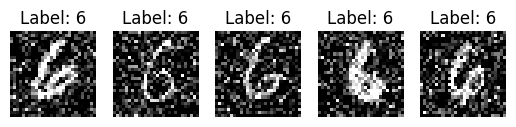

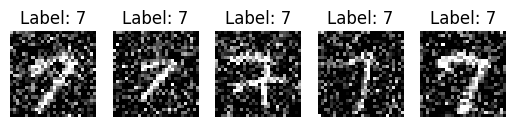

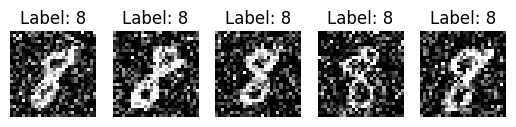

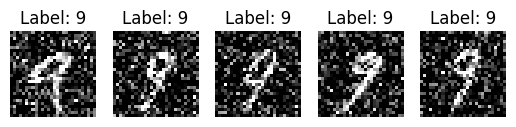

In [8]:
for i in range(10):
    count = 0
    for j in range(len(train_data)):
        if train_labels[j] == i:
            plt.subplot(1, 5, count + 1)
            plt.imshow(noisy_train_data[j], cmap='gray')
            plt.title('Label: ' + str(train_labels[j]))
            plt.axis('off')
            count += 1
        if count == 5:
            break
    plt.show()

In [9]:
autoencoder_train_dataset = torch.utils.data.TensorDataset(
    noisy_train_data.unsqueeze(1),train_data.unsqueeze(1)
)

autoencoder_test_dataset = torch.utils.data.TensorDataset(
    noisy_test_data.unsqueeze(1),test_data.unsqueeze(1)
)

autoencoder_val_dataset = torch.utils.data.TensorDataset(
    noisy_val_data.unsqueeze(1),val_data.unsqueeze(1)
)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
def train_autoencoder(train_dataset, val_dataset, epochs=10, batch_size=64, lr=0.001, verbose=True):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    model = Autoencoder()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels/255)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))
        if verbose:
            print('Epoch: ', epoch + 1, 'Train Loss: ', train_loss[-1])
        model.eval()
        running_loss = 0.0
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels/255)
            running_loss += loss.item()
        val_loss.append(running_loss / len(val_loader))
        if verbose:
            print('Epoch: ', epoch + 1, 'Validation Loss: ', val_loss[-1])
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    return train_loss, val_loss, model

Epoch:  1 Train Loss:  0.01110706853030054
Epoch:  1 Validation Loss:  0.007400836194334905
Epoch:  2 Train Loss:  0.007163301087639597
Epoch:  2 Validation Loss:  0.00695494001236143
Epoch:  3 Train Loss:  0.006887107816003168
Epoch:  3 Validation Loss:  0.006741597794609357
Epoch:  4 Train Loss:  0.00669981144806918
Epoch:  4 Validation Loss:  0.006577950607560858
Epoch:  5 Train Loss:  0.006584191248249596
Epoch:  5 Validation Loss:  0.00649679848287679
Epoch:  6 Train Loss:  0.006475873121186672
Epoch:  6 Validation Loss:  0.006449575365014091
Epoch:  7 Train Loss:  0.006418381156661855
Epoch:  7 Validation Loss:  0.006354748371611291
Epoch:  8 Train Loss:  0.006360922657820346
Epoch:  8 Validation Loss:  0.00632529562527809
Epoch:  9 Train Loss:  0.006317227166574782
Epoch:  9 Validation Loss:  0.006328233016678427
Epoch:  10 Train Loss:  0.00627619942859806
Epoch:  10 Validation Loss:  0.006299395373539079


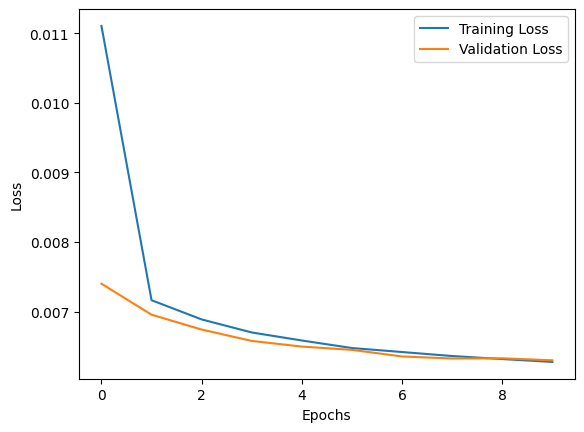

In [14]:
train_loss, val_loss, autoencoder_model = train_autoencoder(autoencoder_train_dataset, autoencoder_val_dataset, epochs=10, batch_size=128, lr=0.001, verbose=True)

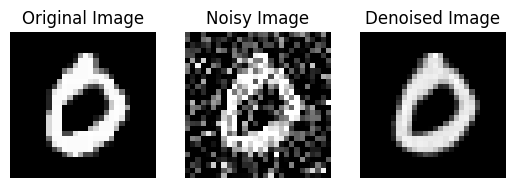

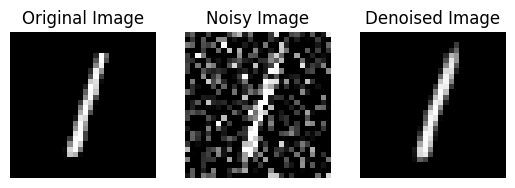

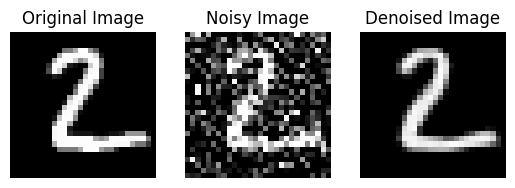

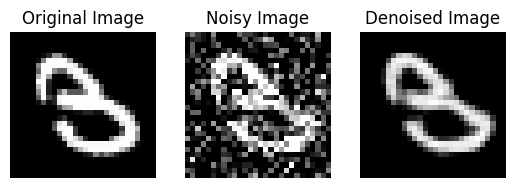

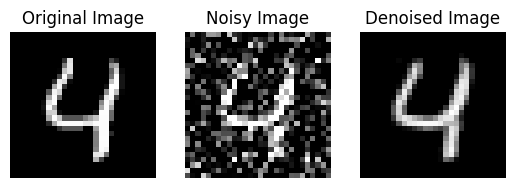

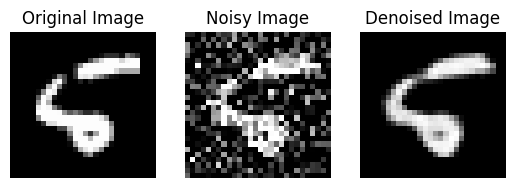

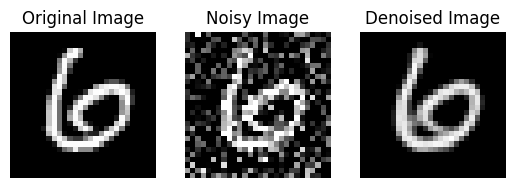

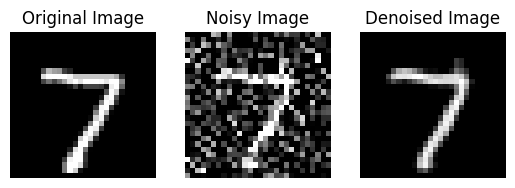

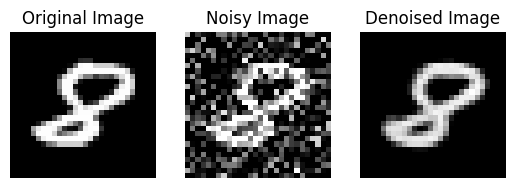

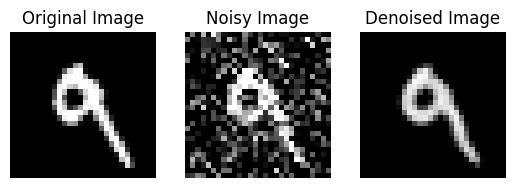

In [20]:
# visualizing the original and noisy and denoised images for all labels

def visualize(autoencoder_model, dataset, labels):
    autoencoder_model.eval()
    for i in range(10):
        for j in range(len(dataset)):
            if labels[j] == i:
                plt.subplot(1, 3, 1)
                plt.imshow(dataset[j][1].squeeze(0), cmap='gray')
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.imshow(dataset[j][0].squeeze(0), cmap='gray')
                plt.title('Noisy Image')
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.imshow(autoencoder_model(dataset[j][0].unsqueeze(0)).squeeze().detach().numpy(), cmap='gray')
                plt.title('Denoised Image')
                plt.axis('off')
                break                
        plt.show()

visualize(autoencoder_model, autoencoder_test_dataset, test_labels)

In [21]:
autoencoder_model.eval()
test_loss = 0.0
criterion = torch.nn.MSELoss()
for i, data in enumerate(autoencoder_test_dataset):
    inputs, labels = data
    outputs = autoencoder_model(inputs)
    loss = criterion(outputs, labels/255)
    test_loss += loss.item()
test_loss /= len(autoencoder_test_dataset)
print('Test Loss: ', test_loss)

Test Loss:  0.006239376187638845
